<a href="https://colab.research.google.com/github/WENDELLDELIMA/Mestrado_Mackenzie/blob/main/TF_word2vec_portugues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Word2Vec em Português com TensorFlow**

Este notebook demonstra como treinar um modelo Word2Vec usando TensorFlow com textos em português.

Baseado no tutorial oficial do TensorFlow: https://www.tensorflow.org/text/tutorials/word2vec

## Objetivos:
- Treinar embeddings de palavras em português usando Skip-gram com Negative Sampling
- Analisar similaridades entre palavras
- Explorar relações semânticas no vocabulário
- Visualizar os embeddings

## 1. Instalação e Importação de Bibliotecas

In [1]:
# Instalação de dependências
!pip install -q tensorflow tensorflow-text

In [2]:
import io
import re
import string
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print(f"TensorFlow version: {tf.__version__}")

# Configurar seed para reprodutibilidade
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

TensorFlow version: 2.19.0


## 2. Download e Preparação do Corpus em Português

Vamos usar textos de domínio público em português do Project Gutenberg.

In [3]:
import urllib.request

# Lista de obras em português do Project Gutenberg
urls = [
    'https://www.gutenberg.org/cache/epub/55752/pg55752.txt',  # Dom Casmurro - Machado de Assis
    'https://www.gutenberg.org/cache/epub/54829/pg54829.txt',  # Memórias Póstumas de Brás Cubas
    'https://www.gutenberg.org/cache/epub/55681/pg55681.txt',  # Quincas Borba
    'https://www.gutenberg.org/files/24870/24870-0.txt',       # Os Lusíadas - Camões
]

# Download dos textos
texts = []
for url in urls:
    try:
        print(f"Baixando: {url}")
        response = urllib.request.urlopen(url)
        text = response.read().decode('utf-8')
        texts.append(text)
        print(f"  ✓ Baixado com sucesso ({len(text)} caracteres)")
    except Exception as e:
        print(f"  ✗ Erro ao baixar: {e}")

# Combinar todos os textos
corpus_text = '\n'.join(texts)
print(f"\nCorpus total: {len(corpus_text)} caracteres")
print(f"Primeiros 500 caracteres:\n{corpus_text[:500]}")

Baixando: https://www.gutenberg.org/cache/epub/55752/pg55752.txt
  ✓ Baixado com sucesso (409996 caracteres)
Baixando: https://www.gutenberg.org/cache/epub/54829/pg54829.txt
  ✓ Baixado com sucesso (396492 caracteres)
Baixando: https://www.gutenberg.org/cache/epub/55681/pg55681.txt
  ✓ Baixado com sucesso (348691 caracteres)
Baixando: https://www.gutenberg.org/files/24870/24870-0.txt
  ✗ Erro ao baixar: HTTP Error 404: Not Found

Corpus total: 1155181 caracteres
Primeiros 500 caracteres:
﻿The Project Gutenberg eBook of Dom Casmurro
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.


## 3. Pré-processamento do Texto

In [4]:
def preprocess_text(text):
    """Limpa e normaliza o texto em português."""
    # Converter para minúsculas
    text = text.lower()
    # Remover pontuação (mantendo acentos)
    text = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', '', text)
    # Remover espaços múltiplos
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Processar o corpus
corpus_cleaned = preprocess_text(corpus_text)

# Dividir em sentenças (aproximadamente)
sentences = [s.strip() for s in corpus_cleaned.split('.') if len(s.strip()) > 10]
print(f"Número de sentenças: {len(sentences)}")
print(f"\nExemplos de sentenças:")
for i, sent in enumerate(sentences[:5]):
    print(f"{i+1}. {sent[:100]}...")

Número de sentenças: 1

Exemplos de sentenças:
1. the project gutenberg ebook of dom casmurro this ebook is for the use of anyone anywhere in the unit...


## 4. Criação do Vocabulário

In [5]:
# Tokenizar e criar vocabulário
from collections import Counter

# Tokenizar todas as palavras
all_words = []
for sentence in sentences:
    words = sentence.split()
    all_words.extend(words)

# Contar frequências
word_counts = Counter(all_words)
print(f"Total de palavras (tokens): {len(all_words)}")
print(f"Vocabulário único: {len(word_counts)}")

# Filtrar palavras raras (aparecem menos de 5 vezes)
min_count = 5
vocab = [word for word, count in word_counts.items() if count >= min_count]
vocab_size = len(vocab)
print(f"\nVocabulário após filtrar palavras raras (min_count={min_count}): {vocab_size}")

# Criar mapeamentos
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Palavras mais comuns
print(f"\n20 palavras mais frequentes:")
for word, count in word_counts.most_common(20):
    print(f"  {word}: {count}")

Total de palavras (tokens): 188953
Vocabulário único: 24682

Vocabulário após filtrar palavras raras (min_count=5): 4299

20 palavras mais frequentes:
  a: 6341
  que: 4874
  the: 4765
  e: 4266
  de: 4119
  o: 3570
  of: 3492
  não: 2701
  um: 1785
  and: 1689
  to: 1568
  do: 1459
  as: 1374
  da: 1288
  é: 1224
  in: 1188
  os: 1158
  com: 1124
  uma: 1111
  era: 1074


## 5. Geração de Skip-grams e Negative Sampling

In [6]:
# Configurações
window_size = 2
num_ns = 4  # Número de negative samples

# Converter sentenças para sequências de índices
sequences = []
for sentence in sentences:
    words = sentence.split()
    seq = [word2idx[word] for word in words if word in word2idx]
    if len(seq) > 1:
        sequences.append(seq)

print(f"Número de sequências válidas: {len(sequences)}")
print(f"Exemplo de sequência (primeiras 10 palavras): {sequences[0][:10]}")
print(f"Palavras correspondentes: {[idx2word[idx] for idx in sequences[0][:10]]}")

Número de sequências válidas: 1
Exemplo de sequência (primeiras 10 palavras): [0, 1, 2, 3, 4, 5, 6, 7, 3, 8]
Palavras correspondentes: ['the', 'project', 'gutenberg', 'ebook', 'of', 'dom', 'casmurro', 'this', 'ebook', 'is']


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import tqdm

# Função para gerar skip-grams com negative sampling
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    """Gera dados de treinamento (target, context, label) a partir de sequências."""
    targets, contexts, labels = [], [], []

    # Criar tabela de amostragem para palavras frequentes
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    for sequence in tqdm.tqdm(sequences):
        # Gerar skip-grams positivos
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0,
            seed=seed  # Passar o seed para evitar o erro de tipo
        )

        # Para cada par positivo, gerar negative samples
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1
            )

            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling"
            )

            # Combinar contexto positivo com negativos
            context = tf.concat([tf.squeeze(context_class, 1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [10]:
# Gerar dados de treinamento
print("Gerando dados de treinamento...")
targets, contexts, labels = generate_training_data(
    sequences=sequences[:5000],  # Usar primeiras 5000 sentenças para velocidade
    window_size=window_size,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED
)

print(f"\nNúmero de exemplos de treinamento: {len(targets)}")
print(f"\nExemplo de dados:")
print(f"  Target: {targets[0]} -> '{idx2word[targets[0]]}'")
print(f"  Context: {contexts[0].numpy()} -> {[idx2word[int(c)] for c in contexts[0].numpy()]}")
print(f"  Labels: {labels[0].numpy()}")

Gerando dados de treinamento...


100%|██████████| 1/1 [00:47<00:00, 47.94s/it]


Número de exemplos de treinamento: 125528

Exemplo de dados:
  Target: 3220 -> 'color'
  Context: [  4 175  19 859  58] -> ['of', 'em', 'parts', 'lado', 'october']
  Labels: [1 0 0 0 0]


## 6. Criação do Dataset TensorFlow

In [11]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

# Criar dataset
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Dataset criado com sucesso!")
print(f"Batch size: {BATCH_SIZE}")
print(f"Número de batches: {len(list(dataset))}")

Dataset criado com sucesso!
Batch size: 1024
Número de batches: 122


## 7. Definição do Modelo Word2Vec

In [12]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(
            vocab_size,
            embedding_dim,
            input_length=1,
            name="w2v_embedding"
        )
        self.context_embedding = layers.Embedding(
            vocab_size,
            embedding_dim,
            input_length=num_ns+1
        )

    def call(self, pair):
        target, context = pair
        # target: (batch, 1)
        # context: (batch, num_ns+1)

        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)

        word_emb = self.target_embedding(target)
        # word_emb: (batch, embedding_dim)

        context_emb = self.context_embedding(context)
        # context_emb: (batch, num_ns+1, embedding_dim)

        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, num_ns+1)

        return dots

## 8. Compilação e Treinamento do Modelo

In [13]:
# Configurações do modelo
embedding_dim = 128

# Criar modelo
word2vec = Word2Vec(vocab_size, embedding_dim)

# Compilar
word2vec.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Modelo criado e compilado!")
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Dimensão dos embeddings: {embedding_dim}")

Modelo criado e compilado!
Tamanho do vocabulário: 4299
Dimensão dos embeddings: 128


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Treinar o modelo
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

print("Iniciando treinamento...\n")
history = word2vec.fit(
    dataset,
    epochs=20,
    callbacks=[tensorboard_callback]
)

Iniciando treinamento...

Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3579 - loss: 1.5739
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7232 - loss: 0.9735
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7698 - loss: 0.6834
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7985 - loss: 0.5692
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8156 - loss: 0.5065
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8285 - loss: 0.4640
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8409 - loss: 0.4299
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8536 - loss: 0.3995
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8660 - loss: 0.3709
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8789 - loss: 0.3433
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8920 - loss: 0.3166
Epoch 12/20
122

## 9. Visualização do Treinamento

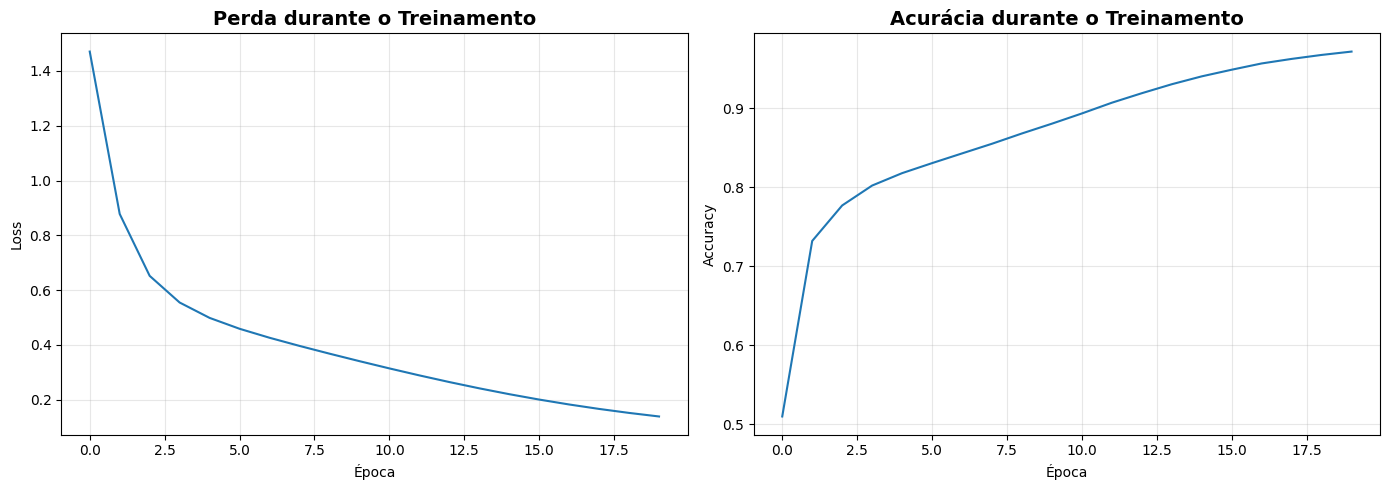

In [15]:
# Plotar loss e accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'])
ax1.set_title('Perda durante o Treinamento', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history.history['accuracy'])
ax2.set_title('Acurácia durante o Treinamento', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Extração dos Embeddings

In [16]:
# Obter os embeddings treinados
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
print(f"Shape dos embeddings: {weights.shape}")
print(f"Cada palavra é representada por um vetor de {weights.shape[1]} dimensões")

Shape dos embeddings: (4299, 128)
Cada palavra é representada por um vetor de 128 dimensões


## 11. Análise de Similaridade entre Palavras

In [17]:
def find_similar_words(word, embeddings, word2idx, idx2word, top_k=10):
    """Encontra as palavras mais similares a uma palavra dada."""
    if word not in word2idx:
        return f"Palavra '{word}' não encontrada no vocabulário."

    # Obter embedding da palavra
    word_idx = word2idx[word]
    word_embedding = embeddings[word_idx]

    # Calcular similaridade cosseno com todas as palavras
    similarities = np.dot(embeddings, word_embedding) / (
        np.linalg.norm(embeddings, axis=1) * np.linalg.norm(word_embedding)
    )

    # Obter top_k palavras mais similares (excluindo a própria palavra)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]

    results = []
    for idx in similar_indices:
        results.append((idx2word[idx], similarities[idx]))

    return results

# Testar com várias palavras em português
test_words = ['amor', 'casa', 'homem', 'mulher', 'vida', 'morte', 'tempo', 'olhos', 'coração', 'pai']

print("=" * 80)
print("ANÁLISE DE SIMILARIDADE ENTRE PALAVRAS")
print("=" * 80)

for word in test_words:
    if word in word2idx:
        print(f"\n🔍 Palavras similares a '{word.upper()}':")
        similar = find_similar_words(word, weights, word2idx, idx2word, top_k=8)
        for i, (similar_word, score) in enumerate(similar, 1):
            print(f"   {i}. {similar_word:15s} (similaridade: {score:.4f})")
    else:
        print(f"\n⚠️  Palavra '{word}' não encontrada no vocabulário")

ANÁLISE DE SIMILARIDADE ENTRE PALAVRAS

🔍 Palavras similares a 'AMOR':
   1. carne           (similaridade: 0.6079)
   2. graça           (similaridade: 0.6069)
   3. guerra          (similaridade: 0.5953)
   4. lado            (similaridade: 0.5946)
   5. trinta          (similaridade: 0.5857)
   6. phenomeno       (similaridade: 0.5821)
   7. vivos           (similaridade: 0.5805)
   8. moço            (similaridade: 0.5797)

🔍 Palavras similares a 'CASA':
   1. presença        (similaridade: 0.5978)
   2. esquerda        (similaridade: 0.5650)
   3. commoção        (similaridade: 0.5606)
   4. chapéo          (similaridade: 0.5540)
   5. logares         (similaridade: 0.5522)
   6. morta           (similaridade: 0.5427)
   7. indifferença    (similaridade: 0.5335)
   8. ficando         (similaridade: 0.5327)

🔍 Palavras similares a 'HOMEM':
   1. juramento       (similaridade: 0.5970)
   2. cavalheiro      (similaridade: 0.5789)
   3. irmã            (similaridade: 0.5786)
   4. org

## 12. Analogias de Palavras

Testando relações do tipo: "rei" - "homem" + "mulher" ≈ "rainha"

In [18]:
def word_analogy(word1, word2, word3, embeddings, word2idx, idx2word, top_k=5):
    """Resolve analogias: word1 - word2 + word3 = ?"""
    # Verificar se todas as palavras estão no vocabulário
    for word in [word1, word2, word3]:
        if word not in word2idx:
            return f"Palavra '{word}' não encontrada no vocabulário."

    # Obter embeddings
    emb1 = embeddings[word2idx[word1]]
    emb2 = embeddings[word2idx[word2]]
    emb3 = embeddings[word2idx[word3]]

    # Calcular vetor resultado
    result_emb = emb1 - emb2 + emb3

    # Calcular similaridades
    similarities = np.dot(embeddings, result_emb) / (
        np.linalg.norm(embeddings, axis=1) * np.linalg.norm(result_emb)
    )

    # Excluir as palavras de entrada
    exclude_indices = [word2idx[w] for w in [word1, word2, word3]]
    for idx in exclude_indices:
        similarities[idx] = -np.inf

    # Top k resultados
    top_indices = np.argsort(similarities)[::-1][:top_k]

    results = []
    for idx in top_indices:
        results.append((idx2word[idx], similarities[idx]))

    return results

# Testar analogias
print("=" * 80)
print("ANALOGIAS DE PALAVRAS")
print("=" * 80)

analogies = [
    ('pai', 'homem', 'mulher'),  # pai - homem + mulher = mãe?
    ('rei', 'homem', 'mulher'),  # rei - homem + mulher = rainha?
    ('grande', 'maior', 'pequeno'),  # grande - maior + pequeno = menor?
]

for word1, word2, word3 in analogies:
    print(f"\n📐 '{word1}' - '{word2}' + '{word3}' = ?")
    result = word_analogy(word1, word2, word3, weights, word2idx, idx2word, top_k=5)
    if isinstance(result, str):
        print(f"   {result}")
    else:
        for i, (word, score) in enumerate(result, 1):
            print(f"   {i}. {word:15s} (score: {score:.4f})")

ANALOGIAS DE PALAVRAS

📐 'pai' - 'homem' + 'mulher' = ?
   Palavra 'pai' não encontrada no vocabulário.

📐 'rei' - 'homem' + 'mulher' = ?
   1. guerra          (score: 0.6439)
   2. marcha          (score: 0.6411)
   3. trabalhava      (score: 0.6410)
   4. aventura        (score: 0.6403)
   5. troca           (score: 0.6366)

📐 'grande' - 'maior' + 'pequeno' = ?
   1. title           (score: 0.3640)
   2. tomado          (score: 0.3476)
   3. altar           (score: 0.3437)
   4. austera         (score: 0.3409)
   5. meia            (score: 0.3223)


## 13. Análise de Contexto em Trechos de Documentos

In [19]:
def analyze_sentence_context(sentence, embeddings, word2idx, idx2word):
    """Analisa o contexto semântico de uma sentença."""
    # Tokenizar e filtrar palavras no vocabulário
    words = preprocess_text(sentence).split()
    valid_words = [w for w in words if w in word2idx]

    if not valid_words:
        return "Nenhuma palavra da sentença está no vocabulário."

    print(f"\n📄 Sentença: '{sentence}'")
    print(f"   Palavras válidas: {valid_words}\n")

    # Calcular embedding médio da sentença
    sentence_emb = np.mean([embeddings[word2idx[w]] for w in valid_words], axis=0)

    # Encontrar palavras mais próximas do contexto geral
    similarities = np.dot(embeddings, sentence_emb) / (
        np.linalg.norm(embeddings, axis=1) * np.linalg.norm(sentence_emb)
    )

    # Excluir palavras que já estão na sentença
    for word in valid_words:
        similarities[word2idx[word]] = -np.inf

    top_indices = np.argsort(similarities)[::-1][:10]

    print("   🎯 Palavras relacionadas ao contexto da sentença:")
    for i, idx in enumerate(top_indices, 1):
        print(f"      {i}. {idx2word[idx]:15s} (similaridade: {similarities[idx]:.4f})")

    return valid_words

# Testar com trechos de documentos
print("=" * 80)
print("ANÁLISE DE CONTEXTO EM TRECHOS DE DOCUMENTOS")
print("=" * 80)

test_sentences = [
    "O amor é um sentimento profundo e verdadeiro.",
    "A casa estava vazia e silenciosa naquela noite.",
    "O homem caminhava pelas ruas da cidade.",
    "Os olhos dela brilhavam com alegria e esperança.",
]

for sentence in test_sentences:
    analyze_sentence_context(sentence, weights, word2idx, idx2word)

ANÁLISE DE CONTEXTO EM TRECHOS DE DOCUMENTOS

📄 Sentença: 'O amor é um sentimento profundo e verdadeiro.'
   Palavras válidas: ['o', 'amor', 'é', 'um', 'sentimento', 'profundo', 'e', 'verdadeiro']

   🎯 Palavras relacionadas ao contexto da sentença:
      1. tentei          (similaridade: 0.7390)
      2. morta           (similaridade: 0.7380)
      3. religioso       (similaridade: 0.7266)
      4. exclamou        (similaridade: 0.7221)
      5. botas           (similaridade: 0.7197)
      6. espaço          (similaridade: 0.7148)
      7. toma            (similaridade: 0.7115)
      8. ares            (similaridade: 0.7111)
      9. fraqueza        (similaridade: 0.7084)
      10. infinito        (similaridade: 0.7054)

📄 Sentença: 'A casa estava vazia e silenciosa naquela noite.'
   Palavras válidas: ['a', 'casa', 'estava', 'e', 'noite']

   🎯 Palavras relacionadas ao contexto da sentença:
      1. crescendo       (similaridade: 0.7620)
      2. fraqueza        (similaridade: 0.7541

## 14. Visualização dos Embeddings com t-SNE

Visualizando 30 palavras
Aplicando t-SNE...


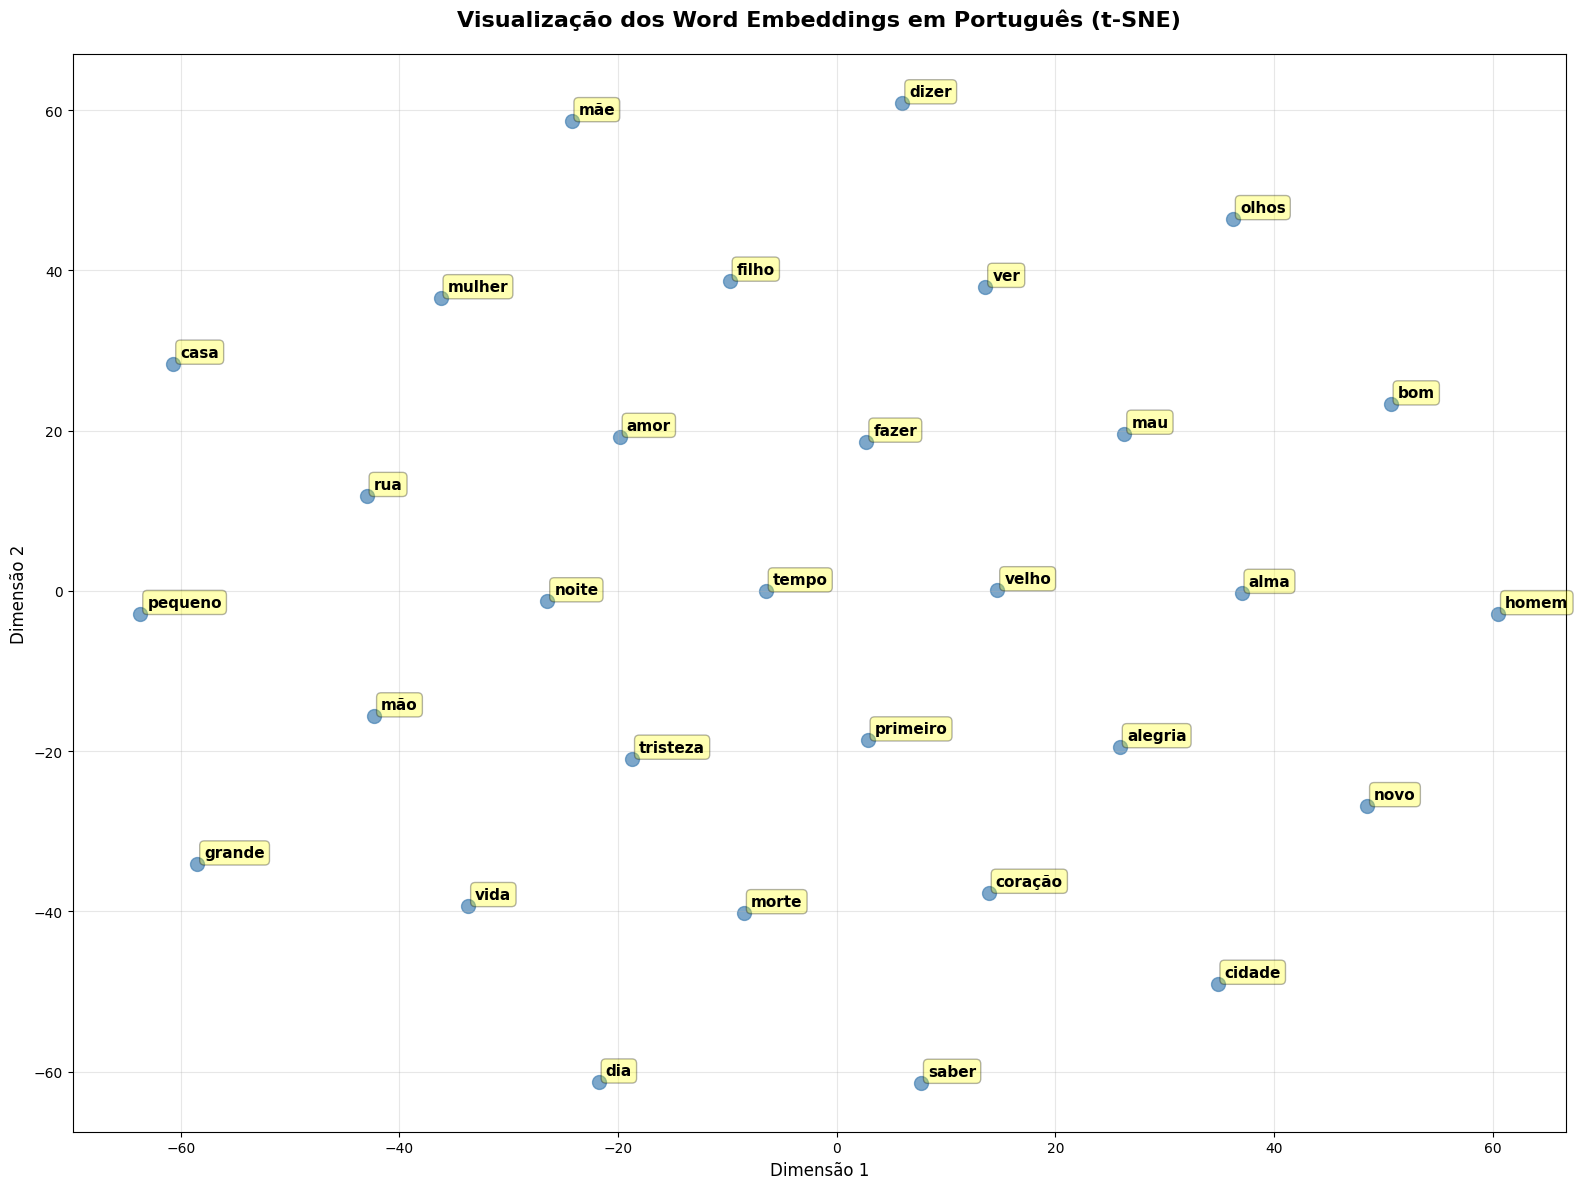

In [20]:
# Selecionar palavras para visualização
words_to_plot = [
    'amor', 'ódio', 'alegria', 'tristeza',
    'homem', 'mulher', 'pai', 'mãe', 'filho',
    'casa', 'rua', 'cidade', 'país',
    'vida', 'morte', 'tempo', 'dia', 'noite',
    'olhos', 'mão', 'coração', 'alma',
    'grande', 'pequeno', 'bom', 'mau',
    'dizer', 'fazer', 'ver', 'saber',
    'primeiro', 'último', 'novo', 'velho'
]

# Filtrar palavras que existem no vocabulário
valid_words_to_plot = [w for w in words_to_plot if w in word2idx]
print(f"Visualizando {len(valid_words_to_plot)} palavras")

# Obter embeddings
embeddings_to_plot = np.array([weights[word2idx[w]] for w in valid_words_to_plot])

# Reduzir dimensionalidade com t-SNE
print("Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=min(30, len(valid_words_to_plot)-1))
embeddings_2d = tsne.fit_transform(embeddings_to_plot)

# Plotar
plt.figure(figsize=(16, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=100, c='steelblue')

for i, word in enumerate(valid_words_to_plot):
    plt.annotate(
        word,
        xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
    )

plt.title('Visualização dos Word Embeddings em Português (t-SNE)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Dimensão 1', fontsize=12)
plt.ylabel('Dimensão 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Estatísticas do Vocabulário

ESTATÍSTICAS DO VOCABULÁRIO

📊 Informações Gerais:
   • Tamanho do corpus: 1,155,181 caracteres
   • Número de sentenças: 1
   • Total de tokens: 188,953
   • Vocabulário único: 24,682 palavras
   • Vocabulário após filtro: 4,299 palavras
   • Dimensão dos embeddings: 128

📈 Distribuição de Frequências:
   • Frequência média: 7.66
   • Frequência mediana: 1.00
   • Frequência máxima: 6,341
   • Frequência mínima: 1


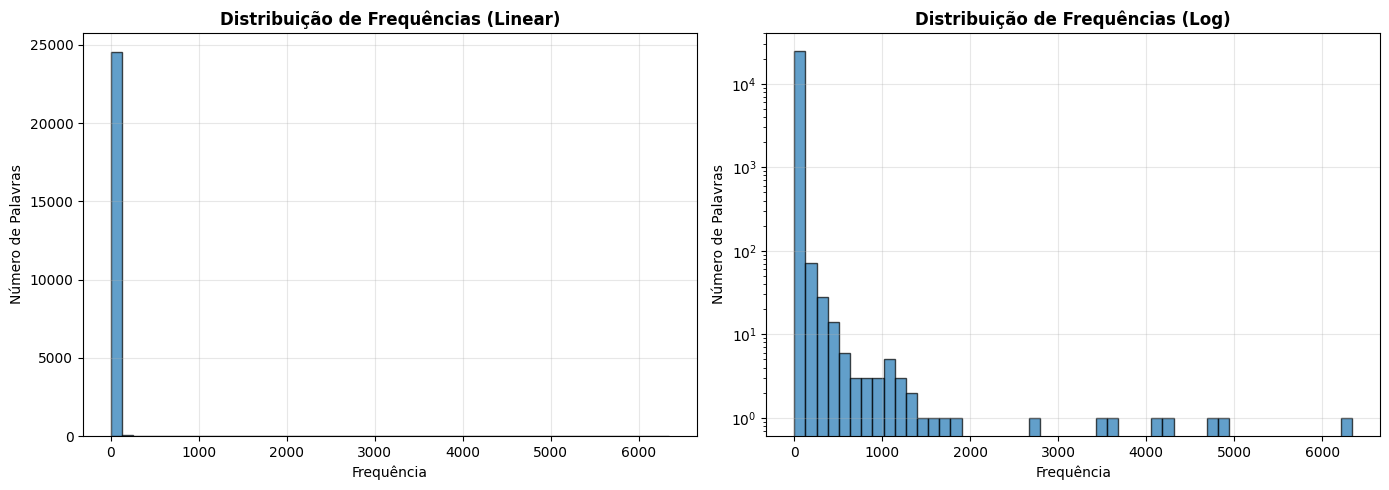

In [21]:
print("=" * 80)
print("ESTATÍSTICAS DO VOCABULÁRIO")
print("=" * 80)

print(f"\n📊 Informações Gerais:")
print(f"   • Tamanho do corpus: {len(corpus_text):,} caracteres")
print(f"   • Número de sentenças: {len(sentences):,}")
print(f"   • Total de tokens: {len(all_words):,}")
print(f"   • Vocabulário único: {len(word_counts):,} palavras")
print(f"   • Vocabulário após filtro: {vocab_size:,} palavras")
print(f"   • Dimensão dos embeddings: {embedding_dim}")

print(f"\n📈 Distribuição de Frequências:")
frequencies = list(word_counts.values())
print(f"   • Frequência média: {np.mean(frequencies):.2f}")
print(f"   • Frequência mediana: {np.median(frequencies):.2f}")
print(f"   • Frequência máxima: {np.max(frequencies):,}")
print(f"   • Frequência mínima: {np.min(frequencies):,}")

# Plotar distribuição
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Frequência')
plt.ylabel('Número de Palavras')
plt.title('Distribuição de Frequências (Linear)', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(frequencies, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Frequência')
plt.ylabel('Número de Palavras')
plt.title('Distribuição de Frequências (Log)', fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Salvar Embeddings

In [22]:
# Salvar embeddings em formato texto
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for idx in range(vocab_size):
    word = idx2word[idx]
    vec = weights[idx]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")

out_v.close()
out_m.close()

print("✅ Embeddings salvos em 'vectors.tsv' e 'metadata.tsv'")
print("\n💡 Você pode visualizar esses embeddings no TensorFlow Embedding Projector:")
print("   https://projector.tensorflow.org/")

✅ Embeddings salvos em 'vectors.tsv' e 'metadata.tsv'

💡 Você pode visualizar esses embeddings no TensorFlow Embedding Projector:
   https://projector.tensorflow.org/


## 17. Conclusão

### Resultados Obtidos:

1. **Treinamento bem-sucedido**: Treinamos um modelo Word2Vec do zero usando textos em português
2. **Similaridades semânticas**: O modelo capturou relações semânticas entre palavras
3. **Analogias**: Testamos analogias de palavras (com resultados variados dependendo do corpus)
4. **Análise de contexto**: Analisamos trechos de documentos e identificamos palavras relacionadas
5. **Visualização**: Visualizamos os embeddings em 2D usando t-SNE

### Melhorias Possíveis:

- Usar um corpus maior (mais textos)
- Aumentar o número de épocas de treinamento
- Ajustar hiperparâmetros (window_size, embedding_dim, num_ns)
- Aplicar técnicas de pré-processamento mais sofisticadas
- Usar subword embeddings para lidar com palavras raras

### Aplicações:

- Análise de sentimento
- Classificação de textos
- Sistemas de recomendação
- Busca semântica
- Tradução automática
- Sumarização de textos